# Roboschool simulations of physical robotics with Amazon SageMaker

---
## Introduction

Roboschool is an [open source](https://github.com/openai/roboschool/tree/master/roboschool) physics simulator that is commonly used to train RL policies for simulated robotic systems.  Roboschool provides 3D visualization of physical systems with multiple joints in contact with each other and their environment.

This notebook will show how to install Roboschool into the SageMaker RL container, and train pre-built robotics applications that are included with Roboschool.

## Pick which Roboschool problem to solve

Roboschool defines a [variety](https://github.com/openai/roboschool/blob/master/roboschool/__init__.py) of Gym environments that correspond to different robotics problems.  Here we're highlighting a few of them at varying levels of difficulty:

- **Reacher (easy)** - a very simple robot with just 2 joints reaches for a target
- **Hopper (medium)** - a simple robot with one leg and a foot learns to hop down a track 
- **Humanoid (difficult)** - a complex 3D robot with two arms, two legs, etc. learns to balance without falling over and then to run on a track

The simpler problems train faster with less computational resources.  The more complex problems are more fun.

In [1]:
# Uncomment the problem to work on
roboschool_problem = 'cartpole'
#roboschool_problem = 'hopper'
#roboschool_problem = 'humanoid'

## Pre-requisites 

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [2]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
import numpy as np
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [3]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-ap-northeast-1-669108200413/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [4]:
# create a descriptive job name 
job_name_prefix = 'rl-gym-'+roboschool_problem

### Configure where training happens

You can train your RL training jobs using the SageMaker notebook instance or local notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`.

In [5]:
# run in local_mode on this machine, or as a SageMaker TrainingJob?
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.c5.2xlarge"

### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

In [6]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::669108200413:role/service-role/AmazonSageMaker-ExecutionRole-20190324T002031


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker and docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [7]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Build docker container

We must build a custom docker container with Roboschool installed.  This takes care of everything:

1. Fetching base container image
2. Installing Roboschool and its dependencies
3. Uploading the new container image to ECR

This step can take a long time if you are running on a machine with a slow internet connection.  If your notebook instance is in SageMaker or EC2 it should take 3-10 minutes depending on the instance type.


In [10]:
%%time

cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-gym-ray-%s" % cpu_or_gpu
docker_build_args = {
    'CPU_OR_GPU': cpu_or_gpu, 
    'AWS_REGION': boto3.Session().region_name,
}
custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using ECR image %s" % custom_image_name)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
Building docker image sagemaker-gym-ray-cpu from Dockerfile
$ docker build -t sagemaker-gym-ray-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=ap-northeast-1
Sending build context to Docker daemon    320kB
Step 1/11 : ARG CPU_OR_GPU
Step 2/11 : ARG AWS_REGION
Step 3/11 : FROM 520713654638.dkr.ecr.${AWS_REGION}.amazonaws.com/sagemaker-rl-tensorflow:ray0.5.3-${CPU_OR_GPU}-py3
 ---> b522ab9d6e52
Step 4/11 : WORKDIR /opt/ml
 ---> Using cache
 ---> cff84b097a3f
Step 5/11 : RUN apt-get update && apt-get install -y       git cmake ffmpeg pkg-config       qtbase5-dev libqt5opengl5-dev libassimp-dev       libpython3.5-dev libtinyxml-dev     && cd 

## Write the Training Code

The training code is written in the file “train-coach.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function. 

In [11]:
!pygmentize src/train-{roboschool_problem}.py

import json
import os

import gym
import ray
from ray.tune import run_experiments
from ray.tune.registry import register_env

from sagemaker_rl.ray_launcher import SageMakerRayLauncher


def create_environment(env_config):
    # This import must happen inside the method so that worker processes import this code
    return gym.make('CartPole-v0')


class MyLauncher(SageMakerRayLauncher):

    def register_env_creator(self):
        register_env("CartPole-v0", create_environment)

    def get_experiment_config(self):
        return {
          "training": { 
            "env": "CartPole-v0",
            "run": "PPO",
            "stop": {
              "episode_reward_mean": 200,
            },
            "config": {
              "gamma": 0.995,
              "kl_coeff": 1.0,
              "num_sgd_iter": 20,
              "lr": 0.0001,
              "sgd_minibatch_size": 1000,
              "train_batch_size": 25000,
              "monitor": True,  # Record videos.
              "mode

## Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET or the RLRAY_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

In [12]:
%%time

metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)
    
estimator = RLEstimator(entry_point="train-%s.py" % roboschool_problem,
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        hyperparameters={
                          # Attention scientists!  You can override any Ray algorithm parameter here:
                          #"rl.training.config.horizon": 5000,
                          #"rl.training.config.num_sgd_iter": 10,
                        }
                    )

estimator.fit(wait=local_mode)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

INFO:sagemaker:Creating training-job with name: rl-gym-cartpole-2019-03-27-13-01-42-105


Training job: rl-gym-cartpole-2019-03-27-13-01-42-105
CPU times: user 94.9 ms, sys: 8.6 ms, total: 103 ms
Wall time: 382 ms


## Visualization

RL training can take a long time.  So while it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that.

In [13]:
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-gym-cartpole-2019-03-27-13-01-42-105
S3 job path: s3://sagemaker-ap-northeast-1-669108200413/rl-gym-cartpole-2019-03-27-13-01-42-105
Intermediate folder path: s3://sagemaker-ap-northeast-1-669108200413/rl-gym-cartpole-2019-03-27-13-01-42-105/output/intermediate/
Create local folder /tmp/rl-gym-cartpole-2019-03-27-13-01-42-105


### Fetch videos of training rollouts
Videos of certain rollouts get written to S3 during training.  Here we fetch the last 10 videos from S3, and render the last one.

In [14]:
recent_videos = wait_for_s3_object(
            s3_bucket, intermediate_folder_key, tmp_dir, 
            fetch_only=(lambda obj: obj.key.endswith(".mp4") and obj.size>0), 
            limit=10, training_job_name=job_name)

Waiting for s3://sagemaker-ap-northeast-1-669108200413/rl-gym-cartpole-2019-03-27-13-01-42-105/output/intermediate/...
Only downloading 10 of 62 files


In [15]:
last_video = sorted(recent_videos)[-1]  # Pick which video to watch
os.system("mkdir -p ./src/tmp_render/ && cp {} ./src/tmp_render/last_video.mp4".format(last_video))
HTML('<video src="./src/tmp_render/last_video.mp4" controls autoplay></video>')

### Plot metrics for training job
We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in CloudWatch metrics.  We can plot this to see the performance of the model over time.

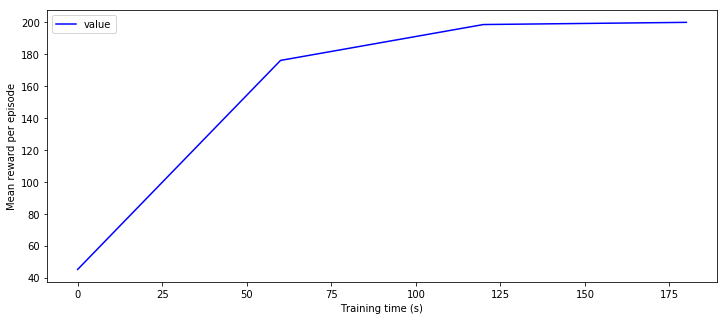

In [16]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

if not local_mode:
    df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
    num_metrics = len(df)
    if num_metrics == 0:
        print("No algorithm metrics found in CloudWatch")
    else:
        plt = df.plot(x='timestamp', y='value', figsize=(12,5), legend=True, style='b-')
        plt.set_ylabel('Mean reward per episode')
        plt.set_xlabel('Training time (s)')
else:
    print("Can't plot metrics in local mode.")

### Monitor training progress
You can repeatedly run the visualization cells to get the latest videos or see the latest metrics as the training job proceeds.

## Evaluation of RL models

We use the last checkpointed model to run evaluation for the RL Agent. 

### Load checkpointed model

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the checkpoint channel. In local mode, we can simply use the local directory, whereas in the SageMaker mode, it needs to be moved to S3 first.

In [17]:
if local_mode:
    model_tar_key = "{}/model.tar.gz".format(job_name)
else:
    model_tar_key = "{}/output/model.tar.gz".format(job_name)
    
local_checkpoint_dir = "{}/model".format(tmp_dir)

wait_for_s3_object(s3_bucket, model_tar_key, tmp_dir, training_job_name=job_name)  

if not os.path.isfile("{}/model.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File model.tar.gz not found")
    
os.system("mkdir -p {}".format(local_checkpoint_dir))
os.system("tar -xvzf {}/model.tar.gz -C {}".format(tmp_dir, local_checkpoint_dir))

print("Checkpoint directory {}".format(local_checkpoint_dir))

Waiting for s3://sagemaker-ap-northeast-1-669108200413/rl-gym-cartpole-2019-03-27-13-01-42-105/output/model.tar.gz...
Checkpoint directory /tmp/rl-gym-cartpole-2019-03-27-13-01-42-105/model


In [18]:
if local_mode:
    checkpoint_path = 'file://{}'.format(local_checkpoint_dir)
    print("Local checkpoint file path: {}".format(local_checkpoint_dir))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(local_checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(local_checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

S3 checkpoint file path: s3://sagemaker-ap-northeast-1-669108200413/rl-gym-cartpole-2019-03-27-13-01-42-105/checkpoint/


In [ ]:
%%time
    
estimator_eval = RLEstimator(entry_point="evaluate-ray.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        base_job_name=job_name_prefix + "-evaluation",
                        hyperparameters={
                            "evaluate_episodes": 5,
                            "algorithm": "PPO",
                            "env": 'Roboschool%s-v1' % roboschool_problem.capitalize()
                        }
                    )

estimator_eval.fit({'model': checkpoint_path})
job_name = estimator_eval.latest_training_job.job_name
print("Evaluation job: %s" % job_name)

INFO:sagemaker:Creating training-job with name: rl-gym-cartpole-evaluation-2019-03-27-13-29-15-282


2019-03-27 13:29:17 Starting - Starting the training job...
2019-03-27 13:29:18 Starting - Launching requested ML instances......
2019-03-27 13:30:24 Starting - Preparing the instances for training...
2019-03-27 13:31:13 Downloading - Downloading input data
2019-03-27 13:31:13 Training - Downloading the training image.....
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-03-27 13:31:58,130 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-03-27 13:31:58,133 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-27 13:31:58,271 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-27 13:31:58,282 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-03-27 13:31:58,291 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sage

### Visualize the output 

Optionally, you can run the steps defined earlier to visualize the output.

# Model deployment

Now let us deploy the RL policy so that we can get the optimal action, given an environment observation.

In [ ]:
from sagemaker.tensorflow.serving import Model

model = Model(model_data=estimator.model_data,
              role=role)

predictor = model.deploy(initial_instance_count=1, instance_type=instance_type)

In [ ]:
# Mapping of environments to observation space
observation_space_mapping = {"reacher": 9,
                             "hopper": 15,
                             "humanoid": 44}

Now let us predict the actions using a dummy observation

In [ ]:
input = {
  'observations': np.ones((observation_space_mapping[roboschool_problem])),
    
}
result = predictor.predict(input)
result

### Clean up endpoint

In [ ]:
predictor.delete_endpoint()